# Partitionierung
Die Partitionierung von Graphen beschreibt einen Prozess, der die Knoten in disjunkte Mengen aufteilt. Diese Partitionierung findet unter anderem Anwendung beim parallelen Rechnen, der Komponentenplatzierung auf Microchips oder auch in der Analyse von Netzwerken.

In [ ]:
import math
import random
import itertools

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from tui_dsmt import hex_colors
from tui_dsmt.graph import StoerWagner
from tui_dsmt.graph.datasets import load_mp_small, load_mp_small_undirected, load_partitioning_example

mp_g, mp_pos     = load_mp_small()
mp_g_u, _        = load_mp_small_undirected()
ex_graph, ex_pos = load_partitioning_example()

## Inhaltsverzeichnis
- [Motivation](#Motivation)
- [Definition](#Definition)
- [Naiver Algorithmus](#Naiver-Algorithmus)
- [Partitionierung ungerichteter Graphen](#Partitionierung-ungerichteter-Graphen)
  - [Kernighan-Lin-Algorithmus](#Kernighan-Lin-Algorithmus)
  - [Spektrale Partitionierung](#Spektrale-Partitionierung)
  - [Spektrale Partitionierung in gewichteten Graphen](#Spektrale-Partitionierung-in-gewichteten-Graphen)
  - [Stoer-Wagner-Algorithmus](#Stoer-Wagner-Algorithmus)
  - [Metis-Algorithmus](#Metis-Algorithmus)
- [Partitionierung gerichteter Graphen](#Partitionierung-gerichteter-Graphen)

## Motivation
Es existieren eine Reihe von Aufgaben, die von mehreren Computer abgearbeitet werden sollen. Zwischen diesen Aufgaben existieren aber Abhängigkeiten in der Form, dass eine Aufgabe vom Ergebnis einer anderen abhängig sein kann. Die Kommunikation zwischen Computern ist aber verhältnismäßig langsam, weshalb diese Zwischenergebnisse nach Möglichkeit nur selten verschickt werden sollen. Es wird also eine Aufteilung der Aufgaben gesucht, die Daten und Zwischenergebnisse mit möglichst hoher Lokalität bearbeitet.

Das Problem wird nun als (gerichteter) Graph modelliert. Die Aufgaben werden zu Knoten, zwischen denen Kanten existieren, falls ein Zwischenergebnis weitergereicht werden muss. Ziel ist es nun eine Aufteilung der Aufgaben auf eine festgelegte Anzahl an Computern (Partitionen) zu finden, sodass möglichst möglichst wenige Zwischenergebnisse zwischen Computern (Kanten zwischen Partitionen) ausgetauscht werden müssen.

In [ ]:
nx.draw(mp_g, mp_pos,
        with_labels=True, font_color='whitesmoke',
        node_color=[hex_colors[0]] * 4 + [hex_colors[1]] * 5)

Im Beispiel sehen Sie einen solchen Aufgabengraphen und eine von Hand vorgegebene Einteilung in zwei Partitionen. Lediglich eine Kante verläuft dabei zwischen den beiden Partitionen.

Später werden wir diese Art der Aufteilung als *Minimum Cut* bezeichnen. Es existieren aber durchaus auch andere Anforderungen an eine Partitionierung als die Zahl der verbindenen Kanten zu minimieren.

## Definition
**Wiederholung**: Die Partitionierung einer Menge $M$ beschreibt die Unterteilung in disjunkte Teilmengen $A_1, \dots, A_n$, sodass
1. $\bigcup_i A_i = M$
2. $A_i \cap A_j = \emptyset \leftrightarrow i \neq j$

Aus $(2)$ folgt außerdem, dass die Teilmengen $A_i$ nicht leer sind.

---

**Definition**: Die Partitionierung eines Graphen $G = (V, E)$ ist eine Zerlegung der *Knotenmenge* $V$ in disjunkte Teilmengen $V_1, \dots, V_n$, sodass oben aufgezählte Bedingungen gelten.

Zusätzliche Bedingungen dieser Partitionierung hängen dann von der Art der Anwendung bzw. der Art der Zielstellung ab. *Minimum Cut* Verfahren versuchen beispielsweise, möglichst wenige Kanten zwischen den Partitionen zu erreichen, während eine bipartite Partitionierung ausschließlich Kanten zwischen den Partitionen erlaubt.

## Naiver Algorithmus
Wie gewohnt soll zunächst ein Algorithmus gezeigt werden, der keine weiteren Annahmen verwendet und stattdessen alle Möglichkeiten probiert. In einem Graphen mit $n$ Knoten kann jeder dieser Knoten zu einer der $k$ Partitionen gehören. Für jeden Kanidaten wird geprüft, ob eine Partition leer bleibt und wie gut er hinsichtlich des vorgegebenen Kriteriums abschneidet.

Der nachfolgende Algorithmus erledigt dies und sucht dabei nach einer Minimum-Cut-Lösung.

In [ ]:
def brute_force_partitions(graph, k):
    best = math.inf
    partitions = None

    for a in itertools.product(range(k), repeat=len(graph)):
        # leere Partitionen suchen
        if len(set(a)) != k:
            continue

        # Kriterium prüfen
        # hier: Anzahl der Kanten
        e = 0
        for u, v in graph.edges:
            if a[u] != a[v]:
                e += 1

        if e < best:
            best = e
            partitions = a

    return partitions

In [ ]:
partitions = brute_force_partitions(mp_g, 2)
print(partitions)

nx.draw(mp_g, mp_pos, with_labels=True, font_color='whitesmoke',
        node_color=[hex_colors[i] for i in partitions])

Im Laufe des Algorithmus ergeben sich $k^n$ Kandiaten. In Graphen relevanter Größe ist das keine akzeptable Laufzeit.

Der vorangestellte Algorithmus prüft übrigens nicht, ob die Partitionen in etwa die selbe Größe besitzen. Mit verändertem $k$ können Sie das daraus resultierende Problem schnell erkennen.

## Partitionierung ungerichteter Graphen

### Kernighan-Lin-Algorithmus
Der Kernighan-Lin-Algorithmus ist ein von Brian W. Kernighan und Shen Lin im Jahre 1969 vorgestellter, heuristischer Algorithmus zur Partitionierung von **ungerichteten** Graphen unter Berücksichtigung von **Kantengewichten**. Gefunden werden dabei in etwa **gleich große Partitionen**. Erfunden wurde er ursprünglich, um die Komponentenplatzierung auf Computerchips zu optimieren, wobei die Länge der Komponenten untereinander möglichst klein gehalten werden sollte.

Zunächst benötigen wir für diesen Algorithmus ein Kostenmodell für jeden Knoten:
- Die Funktion $w : V \times V \rightarrow \mathbb{R}$ ordnet jedem Paar zweier Knoten eine reelle Zahl als Gewicht zu.
- Die *internen Kosten* $I_v$ beschreiben die Summe der Kantengewichte von $v$ zu allen anderen Knoten innerhalb der selben Partition.
- Die *externen Kosten* $E_v$ beschreiben die Summe der Kantengewichte von $v$ zu allen Knoten der anderen Partition.
- Die *Differenzkosten* $D_v = E_v - I_v$ sind die Differenz zwischen externen und internen Kosten.

In [ ]:
def w(graph, u, v):
    if (u, v) in graph.edges:
        return graph.get_edge_data(u, v)['weight']
    elif (v, u) in graph.edges:
        return graph.get_edge_data(v, u)['weight']
    else:
        return 0

def I_v(graph, A, B, v):
    return sum(w(graph, u, v) for u in graph.neighbors(v) if (u in A and v in A) or (u in B and v in B))

def E_v(graph, A, B, v):
    return sum(w(graph, u, v) for u in graph.neighbors(v) if (u in A and v in B) or (u in B and v in A))

def D_v(graph, A, B, v):
    return E_v(graph, A, B, v) - I_v(graph, A, B, v)

Das Ziel des Algorithmus ist dabei eine Unterteilung eines Graphen in zwei Partitionen, die in etwa die selbe Größe besitzen, sodass das summierte Gewicht der zwischen den Partitionen verlaufenden Kanten minimal ist. Das funktioniert wie folgt:
1. Die Knoten werden zu gleichen Teilen in die Partitionen $A$ und $B$ aufgeteilt.
2. Solange eine Verbesserung im vorigen Schleifendurchlauf erreicht wurde:
    1. Für alle Knoten werden die Differenzkosten $D_v$ berechnet.
    2. Angelegt werden die Listen $g_v$, $a_v$ und $b_v$.
    3. Bis kein Paar von Knoten mehr gebildet werden kann, wird:
        1. das Paar $a \in A, b \in B$ ausgewählt, das die höchste Kostenreduktion $g = D_a + D_b - 2 * w(a, b)$ verspricht,
        2. die Knoten $a$ und $b$ für weiteres Vertauschen in dieser Iteration gesperrt,
        3. $g \rightarrow g_v, a \rightarrow a_v, b \rightarrow b_v$ und
        4. die Differenzkosten aktualisiert für alle Knoten in $A \setminus \{a\}$ und $B \setminus \{b\}$.
    4. Gesucht wird das $k$, sodass die Summe über $g_v[0], \dots, g_v[k]$ maximal wird bzw. $\underset{k}{\operatorname{arg\,max}} \sum_{i=0}^k g_v[i]$.
    5. Falls die Summe positiv ist, wird die Vertauschung bis einschließlich $k$ durchgeführt und ein weiterer Schleifendurchlauf erlaubt.

In [ ]:
def kernighan_lin(graph):
    # Zufällige Aufteilung in zwei (nahezu) gleich
    # große Teilmengen:
    all_nodes = list(graph.nodes)
    random.shuffle(all_nodes)

    A = set(all_nodes[:len(all_nodes) // 2])
    B = set(all_nodes[len(all_nodes) // 2:])

    # solange eine Verbesserung erreicht wurde
    # (siehe break am Ende)
    while True:
        # Arbeitskopien von A und B erstellen
        new_A, new_B = A.copy(), B.copy()

        # Menge für bereits getauschten / gesperrten Knoten
        locked = set()

        # Berechnung der Differenzkosten für jeden Knoten
        ds = { node: D_v(graph, new_A, new_B, node) for node in graph }

        # Listen
        gv = []
        av = []
        bv = []

        # solange tauschbare Knoten existieren
        for i in range(len(graph) // 2):
            # Suche nach Paar mit höchster Kostenreduktion
            g, a, b = max(
                (ds[a] + ds[b] - 2 * w(graph, a, b), a, b)
                for a in A if a not in locked
                for b in B if b not in locked
            )

            # Sperren der Knoten
            locked.add(a)
            locked.add(b)

            # Erweitern der Listen
            gv.append(g)
            av.append(a)
            bv.append(b)

            # Anpassung der Differenzkosten
            new_A.remove(a)
            new_B.remove(b)

            ds = { node: D_v(graph, new_A, new_B, node) for node in graph }

        # k finden
        g_max, k = max((sum(gv[:i]), i) for i in range(len(gv)))

        # Vertauschung vornehmen oder Schleife abbrechen
        if g_max > 0:
            for a, b in zip(av[:k], bv[:k]):
                A.remove(a)
                B.add(a)

                B.remove(b)
                A.add(b)
        else:
            break

    return [0 if node in A else 1 for node in graph]

In [ ]:
partitions = kernighan_lin(ex_graph)
print(partitions)

nx.draw(ex_graph, ex_pos, with_labels=True, font_color='whitesmoke',
        node_color=[hex_colors[i] for i in partitions])
nx.draw_networkx_edge_labels(ex_graph, ex_pos, edge_labels=nx.get_edge_attributes(ex_graph, 'weight'), font_color='black')

plt.show()

In den Schleifendurchläufen wird damit gierig (*greedy*) optimiert. Der Algorithmus findet damit auch lokale Optima, die von der zufälligen Startaufteilung abhängen.

**Verständnisfrage:** Welches Ergebnis wird erreicht, wenn alle Kantengewichte im Graphen gleich groß sind?

### Spektrale Partitionierung
Spektrale Partitionierung beschäftigt sich mit der Partitionierung von Graphen mit Hilfe algebraischer Analysen der zugehörigen Matrizen. Sie eignet sich zur Partitionierung **ungerichteter** Graphen mit einer minimalen Anzahl an zwischen den Partitionen verlaufenden Kanten.

- Bereits bekannt ist Ihnen die *Adjazenzmatrix*, die in der Regel mit $A$ bezeichnet wird und deren Einträge $A_{ij}=1$ sind, falls es eine Kante zwischen dem $i$-ten und $j$-ten Knoten gibt, und $0$ andernfalls.
- Die *Gradmatrix* $D$ ist eine Diagonalmatrix, bei der ein Eintrag $D_{ii}$ dem Knotengrad des Knotens $i$ entspricht.
- Die *Laplace-Matrix* $L$ beschreibt die Beziehung zwischen Knoten und Kanten. Sie wird gebildet als $L = D - A$ beziehungsweise $$
L_{ij} = \begin{cases}
    deg(i) & \text{falls } i = j                                                                         \\
    -1     & \text{falls } i \neq j \text{ und eine Kante zwischen } i \text{ und } j \text{ existiert}  \\
    0      & \text{sonst}
\end{cases}
$$

Die spektrale Partitionierung teilt nun den Graphen in zwei Teile und minimiert dabei die Anzahl der Kanten, die zwischen den beiden entstehenden Teilmengen der Knoten verlaufen. Dazu werden die Eigenwerte $\lambda_i$ und die zugehörigen Eigenvektoren $v_i$ der Laplace-Matrix $L$ bestimmt. Zur Erinnerung: Ein Eigenwert mit dem zugehörigen (rechten) Eigenvektor entspricht der nachfolgenden Bedingung. $$ L * v_i = \lambda_i * v_i $$

Die gefundenen Eigenwerte der Matrix werden aufsteigend sortiert. Der kleinste Eigenwert, der nicht $0$ ist, wird auch als Fiedler-Wert bezeichnet. (Bei vollständig verbundenen Graphen erfüllt die Laplace-Matrix Eigenschaften, sodass dies immer der zweitkleinste Eigenwert ist.) Der ihm zugeordnete Fiedler-Vektor enthält wichtige Informationen über die Struktur des Graphen und kann zu dessen Partitionierung verwendet werden.

Das nachfolgende Beispiel verwendet NumPy, um die Eigenvektoren und -werte effizient zu berechnen und anschließend den Fiedler-Vektor zu finden.

In [ ]:
A = nx.to_numpy_array(mp_g_u)
D = np.diag([d for _, d in mp_g_u.degree])
L = D - A

L

In [ ]:
# Achtung: eigh eignet sich nur für symmetrische Matrizen,
# ist dafür aber schneller als eig, liefert nur reelle
# Eigenwerte und diese sogar direkt aufsteigend sortiert!
values, vectors = np.linalg.eigh(L)
fiedler_vector = vectors[:,1]

fiedler_vector

Der Graph kann partitioniert werden, indem die Knoten den Werten im Fiedler-Vektor entsprechend in zwei Gruppen aufgeteilt werden. Ein einfacher Schwellwert zur Aufteilung der Mengen, der häufig verwendet wird, ist das Vorzeichen.

In [ ]:
p1 = [node for val, node in zip(fiedler_vector, mp_g_u.nodes) if val < 0]
p2 = [node for val, node in zip(fiedler_vector, mp_g_u.nodes) if val >= 0]

p1, p2

In [ ]:
partitions = [0 if node in p1 else 1 for node in mp_g_u.nodes]
print(partitions)

nx.draw(mp_g_u, mp_pos, with_labels=True, font_color='whitesmoke',
        node_color=[hex_colors[i] for i in partitions])

plt.show()

Die Schwierigkeit der spektralen Partitionierung besteht also in der Berechnung der Eigenwerte und Eigenvektoren. Das ist als mathematisches Problem gelöst und in NumPy als effizienter Algorithmus enthalten.

Da die Symmetrie der Adjazenzmatrix eine Rolle spielt (nicht nur wegen der Verwendung von `eigh`), lässt sich der Algorithmus nicht ohne Weiteres auf gerichtete Graphen übertragen. Für ungerichtete Graphen stellt die spektrale Partitionierung jedoch einen einfach umzusetzenden Algorithmus dar, um Partitionen zu finden.

### Spektrale Partitionierung in gewichteten Graphen
Durch geringfügige Anpassungen lässt sich die spektrale Partitionierung außerdem auf **gewichtete** Graphen (mit positiven Kantengewichten) übertragen: Sei $W$ zusätzlich eine Matrix, welche an der Position $i,j$ das Gewicht der Kante zwischen den Knoten $i$ und $j$ enthält, sofern diese durch eine Kante verbunden sind, und $0$ andernfalls.

Dann wird die Diagonal-Gradmatrix $D$ so verändert, dass sie die Summe der Gewichte der adjazenten Kanten enthält:

$$
D_{ij} = \begin{cases}
    \sum_k W_{ik} & \text{falls } i=j \\
    0             & \text{sonst}
\end{cases}
$$

In [ ]:
# Die Adjazenzmatrix enthält in NetworkX
# automatisch die Gewichte der Kanten bei
# gewichteten Graphen.
W = nx.to_numpy_array(ex_graph)

# Aufstellen der Gradmatrix
degrees = np.sum(W, axis=1)
D = np.diag(degrees)

# Aufstellen von L
L = D - W
L

Der restliche Algorithmus verläuft wie zuvor:

In [ ]:
# Eigenvektor zum zweitkleinsten Eigenwert finden
values, vectors = np.linalg.eigh(L)
fiedler_vector = vectors[:,1]

# Partitionen bestimmen
p1 = [node for val, node in zip(fiedler_vector, ex_graph.nodes) if val < 0]
p2 = [node for val, node in zip(fiedler_vector, ex_graph.nodes) if val >= 0]

p1, p2

In [ ]:
partitions = [0 if node in p1 else 1 for node in ex_graph.nodes]
print(partitions)

nx.draw(ex_graph, ex_pos, with_labels=True, font_color='whitesmoke',
        node_color=[hex_colors[i] for i in partitions])
nx.draw_networkx_edge_labels(ex_graph, ex_pos, edge_labels=nx.get_edge_attributes(ex_graph, 'weight'), font_color='black')

pass

### Stoer-Wagner-Algorithmus
Der Stoer-Wagner-Algorithmus ist ein weiterer Algorithmus, der dazu verwendet wird, den **minimalen Schnitt** in einem **ungerichteten, gewichteten** Graphen (mit positiven Kantengewichten) zu finden. Der Algorithmus garantiert darüber hinaus, dass tatsächlich der minimale Schnitt gefunden wird, beachtet dabei aber nicht die Größe der Partitionen. Veröffentlicht wurde er von Mechthild Stoer und Frank Wagner im Jahr 1995.

Der Algorithmus durchläuft für einen Graphen $G = (V, E)$ immer $|V| - 1$ Phasen:
- In jeder Phase $i$ wird ein Schnitt in einem Graphen $G_i = (V_i, E_i)$ berechnet.
- $G_1 = G$ entspricht dem Ausgangsgraphen. $G_i$ entsteht durch Verschmelzen von $G_{i-1}$ mit *geeigneten* Knoten.

Im Detail laufen die Phasen wie folgt ab:
- Begonnen wird mit einem beliebigen Knoten $v \in V$. Dann sei die Menge $S_i = \{v\}$.
- Iterativ wird der am stärksten zu $S_i$ verbundene Knoten (größtes Kantengewicht) zu $S_i$ hinzugefügt.
- Seien $s$ und $t$ die als vorletztes bzw. als letztes zu $S_i$ hinzugefügten Knoten. Dann ist $(V_i \setminus \{t\}, \{t\})$ der Schnitt der Phase $i$.
- $G_{i+1}$ entsteht aus $G_i$ durch Verschmelzen der Knoten $s$ und $t$.

Nach Abschluss aller Phasen wird der Schnitt ausgewählt, der das minimale summierte Gewicht der zwischen den Partitionen verlaufenden Kanten besitzt.

Zur Implementierung müssen einige Details beachtet werden. Beim Verschmelzen zweier Knoten in einem Graphen ist das Ziel die Verringerung der Anzahl der Knoten. Die durch die Kanten und insbesondere die Gewichte enthaltene Information soll dabei aber nicht verloren gehen. Bei der Verschmelzung der Knoten $s$ und $t$ zu einem neuen Knoten $s,t$ werden daher Kanten zu allen Nachbarn von $s$ und $t$ inklusive der Gewichte eingefügt. Falls $s$ und $t$ sich einen Nachbarn teilen, wird das Gewicht beider Kanten aufsummiert.

Im nachstehenden Beispiel werden die Knoten $1$ und $3$ zusammengefasst. Zwischen $1$ und $4$ existiert eine Kante mit dem Gewicht $3$ - diese wird übernommen. Zwischen $1$ und $4$ und $3$ und $4$ existiert jeweils eine Kante, sodass die Gewichte summiert werden.

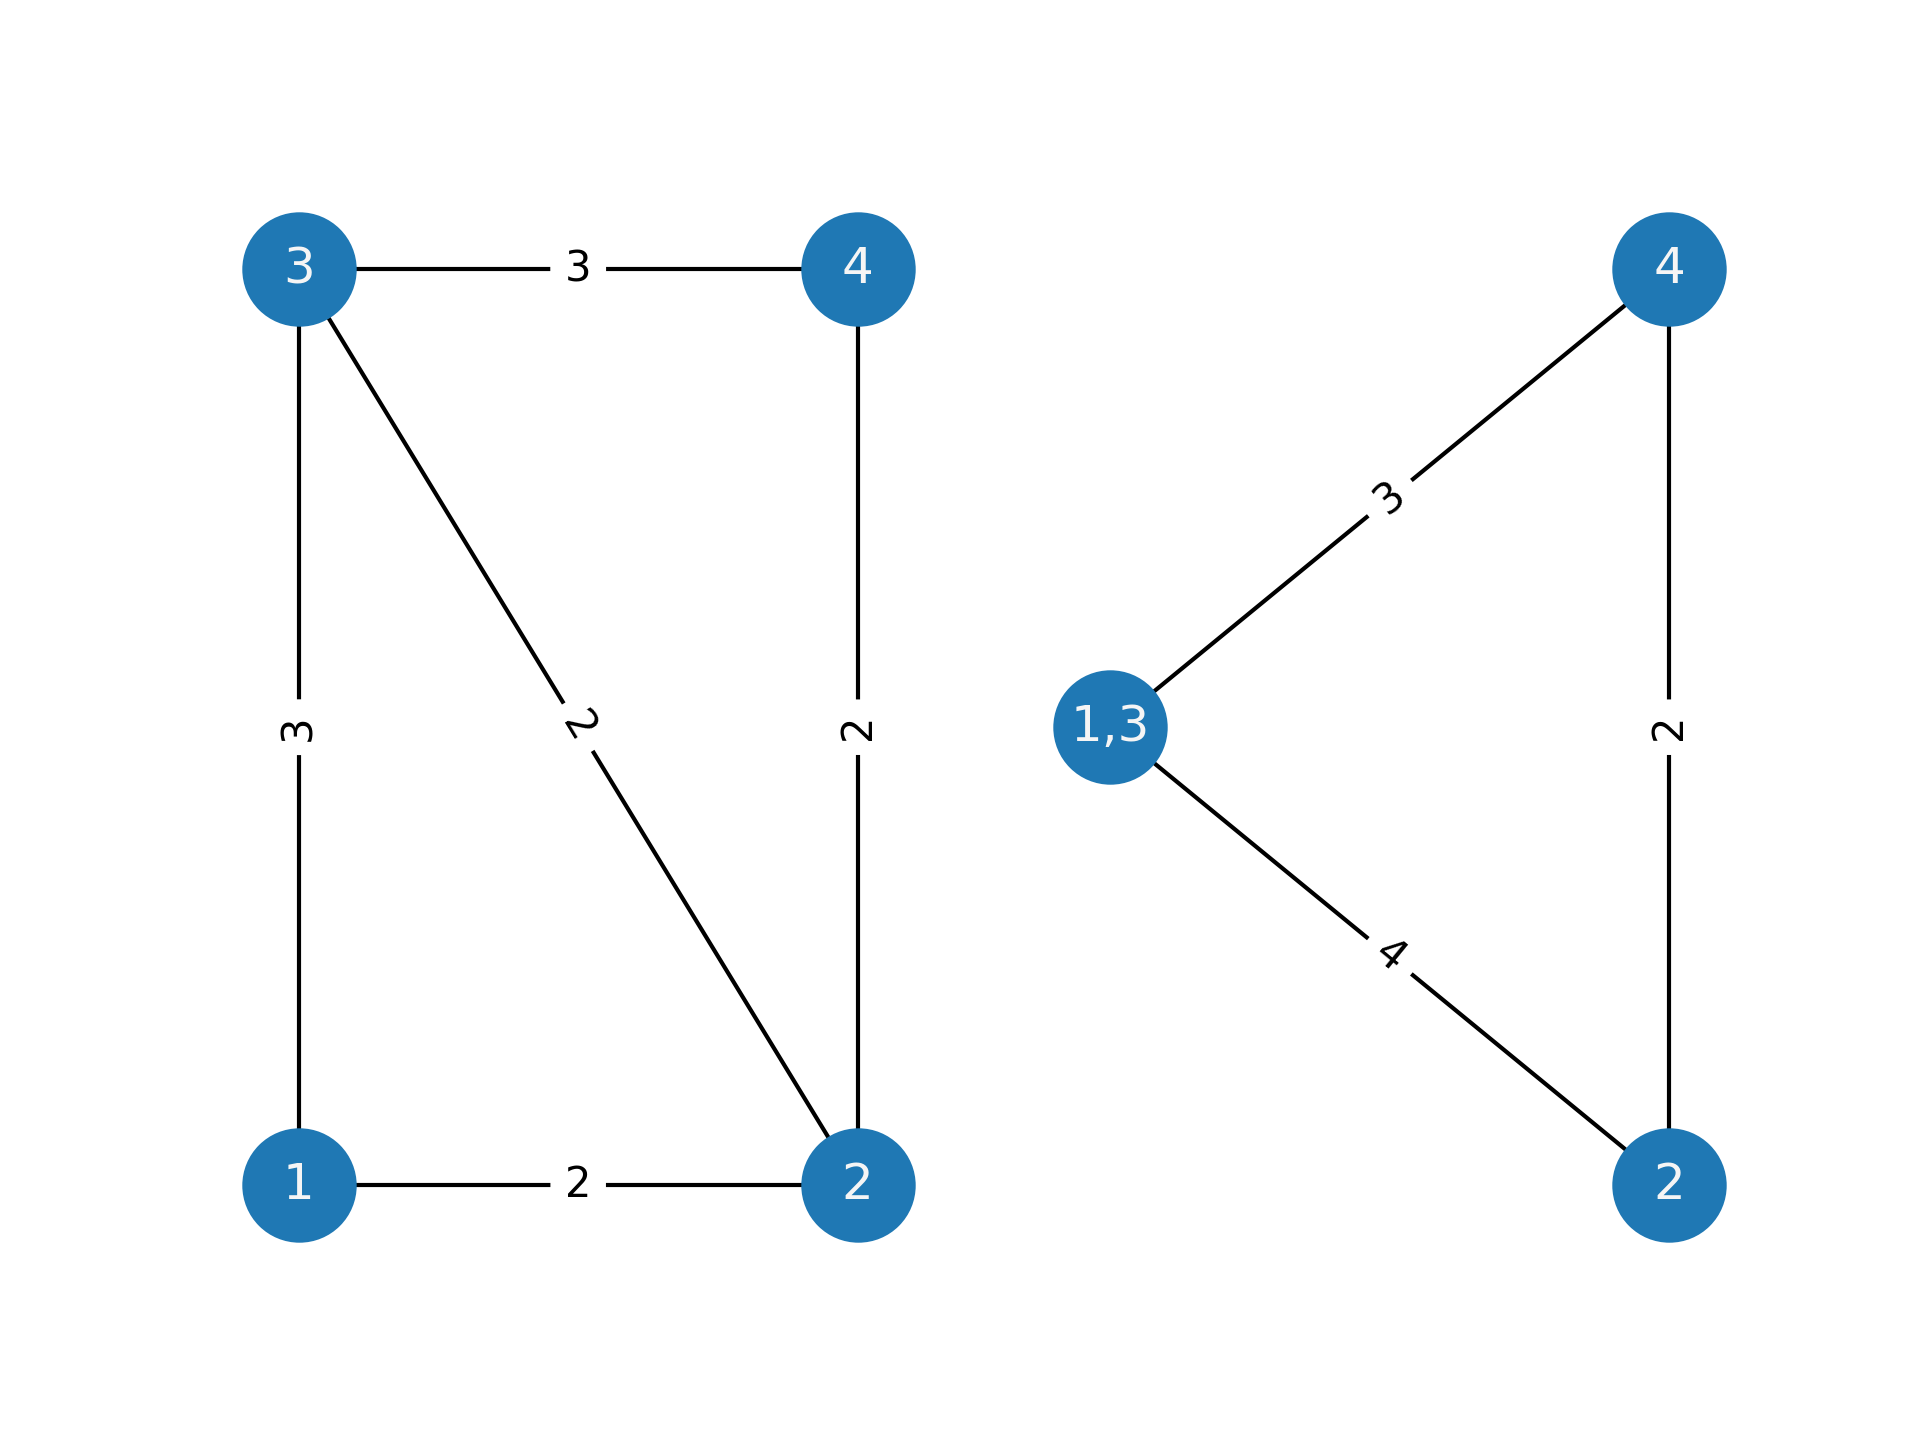

Mit NetworkX könnte der Code zum Vereinigen in etwa so aussehen:

In [ ]:
def merge_nodes(graph, s, t):
    # Kanten und Gewichte zu Nachbarn sammeln
    merged_weights = {}
    for node in (s, t):
        for neighbor in graph.neighbors(node):
            if neighbor not in (s, t):
                edge_weight = graph.get_edge_data(node, neighbor)['weight']
                merged_weights[neighbor] = merged_weights.get(neighbor, 0) + edge_weight

    # Kopie des Graphen anlegen
    # s und t entfernen
    # neuen Knoten mit passenden Gewichten einsetzen
    merged_graph = graph.copy()
    merged_graph.remove_nodes_from((s, t))
    for neighbor, weight in merged_weights.items():
        merged_graph.add_edge(f'{s},{t}', neighbor, weight=weight)

    return merged_graph

Auf Grund der Speicherung der kombinierten Knoten als Zeichenkette müssen diese später wieder "aufgetrennt" werden.

In [ ]:
def split_nodes(*nodes):
    return [
        y
        for node in nodes
        for y in (
            list(map(int, node.split(','))) if isinstance(node, str)
            else [node]
        )
    ]

Der zweite Baustein besteht in der Formulierung der Phasenlogik.

In [ ]:
def minimum_cut_phase(graph, a):
    # Anlegen der Menge S_i
    S = [a]

    # Anlegen der Variablen für s und t
    s, t = None, None

    # Iteration in Länge der Knotenmenge - 1
    for _ in range(len(graph) - 1):
        # Suche nach dem Knoten mit der stärksten
        # Verbindung zur Menge S_i
        ranking = {}

        for node in S:
            for neighbor in graph.neighbors(node):
                if neighbor in S:
                    continue

                edge_weight = graph.get_edge_data(node, neighbor)['weight']
                ranking[neighbor] = ranking.get(neighbor, 0) + edge_weight

        # Auswahl des Knotens mit der stärksten
        # Verbindung Hinzufügen zur Menge S_i
        best = max(ranking.keys(), key=ranking.get)
        S.append(best)

        # Aktualisieren von s und t
        s = t
        t = best

    # Schnitt wie zuvor beschrieben bestimmen
    # und Zeichenketten dabei auftrennen
    cut = split_nodes(*S[:-1]), split_nodes(t)

    # Knoten im Graphen zusammenfassen
    # im letzten Durchlauf ist s = None!
    if s is not None:
        next_graph = merge_nodes(graph, s, t)
    else:
        next_graph = None

    # Schnitt, Graphen mit zusammengefassten Knoten
    # und Gewicht zurückgeben
    return cut, next_graph, ranking[best]

Zuletzt lassen sich die Funktionen zum Stoer-Wagner-Algorithmus kombinieren:

In [ ]:
def stoer_wagner(graph):
    # Variablen zum Speichern des besten Schnitts
    best_weight = math.inf
    best_cut = graph

    # zufälliger Startknoten
    random_node = random.choice(list(graph.nodes))
    print(f'Zufälliger Startknoten: {random_node}')

    # Iterationen
    for i in range(1, len(graph)):
        cut, graph, weight = minimum_cut_phase(graph, random_node)

        print(f'Schnitt {i}: {cut} mit Gewicht {weight}')

        if weight < best_weight:
            best_weight = weight
            best_cut = cut

    return best_cut


p1, p2 = stoer_wagner(ex_graph)
p1, p2

In [ ]:
partitions = [0 if node in p1 else 1 for node in ex_graph.nodes]
print(partitions)

nx.draw(ex_graph, ex_pos, with_labels=True, font_color='whitesmoke',
        node_color=[hex_colors[i] for i in partitions])
nx.draw_networkx_edge_labels(ex_graph, ex_pos, edge_labels=nx.get_edge_attributes(ex_graph, 'weight'), font_color='black')

plt.show()

Im Folgenden finden Sie einen beispielhaften Durchlauf de Algorithmus. Denken Sie aber daran, dass jeder Cut zwischengespeichert und zum Schluss der beste ausgewählt wird. Der letzte Frame der Animation stellt also nicht das Endergebnis dar!

In [ ]:
StoerWagner(ex_graph, ex_pos, 2)

### Metis-Algorithmus
Der Metis Algorithmus ist eine ebenfalls weit verbreitete Methode zur Graphpartitionierung, die darauf abzielt, einen Graphen in mehrere Teilgraphen zu unterteilen, sodass die Anzahl der Kanten, die zwischen diesen Teilgraphen verlaufen, minimiert wird. Er wurde von George Karypis und Vipin Kumar entwickelt, wobei das Wort Metis der griechischen Mythologie entstammt und in etwa Weisheit oder Scharfsinn bedeutet.

Für einen **ungerichteten, gewichteten** Graphen $G = (V, E)$ verläuft der Algorithmus in drei Stufen:

1. **Verkleinerung (*Coarsening*):** Der Graph wird schrittweise in einer Sequenz von Graphen $G_0 = (V, E), G_1 = (V_1, E_1), \dots, G_n = (V_n, E_n)$ verkleinert, wobei $G_0 = G$ der Originalgraph ist und für alle $i<j$ gilt, dass $|V_i| > |V_j|$. Diese Verkleinerung wird erreicht, indem Paare von Knoten zusammengefasst werden, bis der Graph eine handhabbare Größe erreicht. Die Knotenpaare müssen so gewählt werden, dass sie stark miteinander verbunden sind, was die Wahrscheinlichkeit verringert, dass die späteren Partitionen viele Kanten untereinander besitzen.
2. **Initiale Partitionierung:** Der stark reduzierte Graph wird partitioniert. Da dieser relativ klein ist, können genaue und aufwendige Methoden zur Partitionierung verwendet werden. Das Ziel ist es, eine anfängliche Partitionierung zu finden, welche die Anzahl der zwischen den Teilgraphen verlaufenden Kanten minimiert.
3. **Vergrößerung (*Refinement*):** Der Graph wird schrittweise in seine ursprüngliche Größe zurückverwandelt. Bei jedem Schritt werden die Partitionen des verkleinerten Graphen auf den nächstgrößeren übertragen und zusätzlich verfeinert.

Im Folgenden werden die drei Stufen als einzelne Funktionen dargestellt und wie üblich zum Ende kombiniert.

Die **Verkleinerung** besteht daraus, Paare adjazenter Knoten zu finden und diese zusammenzufassen. Diese Paare werden gierig (*greedy*) entweder zufällig zugeordnet oder anhand des größten Kantengewichts. Beim Zusammenfassen ist darauf zu achten, dass die Kanten zwischen den entstehenden Gruppen insofern erhalten bleiben, dass ihre Kantengewichte wie zuvor addiert werden.

In [ ]:
def coarsen_graph(graph):
    smaller_graph = graph.copy()

    # Paare von Knoten finden
    all_nodes = list(graph.nodes)
    random.shuffle(all_nodes)

    while len(all_nodes) >= 2:
        # Knoten entnehmen
        v = all_nodes.pop()

        # Suche nach dem Nachbarn, der bisher
        # noch keiner Gruppe zugeordnet wurde
        # und mit dem größten Kantengewicht
        # der verbleibenden verbunden ist
        remaining_neighbors = [node for node in graph.neighbors(v) if node in all_nodes]
        if len(remaining_neighbors) == 0:
            continue

        w = max(remaining_neighbors, key=lambda node: smaller_graph.get_edge_data(v, node)['weight'])

        # Knoten vereinigen und auch w aus
        # der Liste entfernen
        smaller_graph = merge_nodes(smaller_graph, v, w)
        all_nodes.remove(w)

    return smaller_graph


new_G1 = coarsen_graph(ex_graph)

new_G1_pos = nx.spring_layout(new_G1)
nx.draw(new_G1, new_G1_pos, with_labels=True, font_color='black')
nx.draw_networkx_edge_labels(new_G1, new_G1_pos, edge_labels=nx.get_edge_attributes(new_G1, 'weight'), font_color='black')

Die **initiale Partitionierung** erfolgt durch einen beliebigen Partitionierungsalgorithmus. Da der Graph nun relativ klein ist, können auch ineffiziente Algorithmen angewendet werden.

In [ ]:
partitions = kernighan_lin(new_G1)
print(partitions)

nx.draw(new_G1, new_G1_pos, with_labels=True, font_color='black',
        node_color=[hex_colors[i] for i in partitions])
nx.draw_networkx_edge_labels(new_G1, new_G1_pos, edge_labels=nx.get_edge_attributes(new_G1, 'weight'), font_color='black')

Die **Vergrößerung** überträgt zunächst die Partitionierung des kleinen Graphen $G_i$ auf den nächst größeren $G_{i-1}$. Anschließend wird versucht, die aktuelle Partitionierung zu verbessern. Nachfolgend wird dazu geprüft, ob das Verschieben einzelner Knoten in die jeweils andere Partition eine Verbesserung zur Folge hätte.

In [ ]:
def uncoarse_graph(original_graph, coarsed_graph, coarsed_partitions):
    original_partitions = []

    for original_node in original_graph.nodes:
        for coarsed_node, partition in zip(coarsed_graph.nodes, coarsed_partitions):
            if str(original_node) in coarsed_node:
                original_partitions.append(partition)

    return original_partitions

In [ ]:
G0_partitions = uncoarse_graph(ex_graph, new_G1, partitions)
print(ex_graph)

nx.draw(ex_graph, ex_pos, with_labels=True, font_color='black',
        node_color=[hex_colors[i] for i in G0_partitions])
nx.draw_networkx_edge_labels(ex_graph, ex_pos, edge_labels=nx.get_edge_attributes(ex_graph, 'weight'), font_color='black')

In [ ]:
def refine_partitions(graph, partitions):
    p1 = set(node for node, partition in zip(graph.nodes, partitions) if partition == 0)
    p2 = set(node for node, partition in zip(graph.nodes, partitions) if partition == 1)

    for node in list(p1):
        if D_v(graph, p1, p2, node) > 0:
            print(f'verschiebe {node} von p1 nach p2')
            p1.remove(node)
            p2.add(node)

    for node in list(p2):
        if D_v(graph, p1, p2, node) > 0:
            print(f'verschiebe {node} von p2 nach p1')
            p2.remove(node)
            p1.add(node)

    return [0 if node in p1 else 1 for node in graph.nodes]


refine_partitions(ex_graph, G0_partitions)

Um den Originalgraph wiederherzustellen, muss das Vergrößern und Verbessern so oft angewendet werden wie das Verkleinern.

Beachten Sie, dass es sich bei der gezeigten Variante um eine stark vereinfachte Version des Metis-Algorithmus handelt. In einer echten Anwendung sind zahlreiche Verfeinerungen und Optimierungen möglich, die nicht nur die Qualität der Partitionen verbessern, sondern auch die Laufzeit massiv senken und von Parallelisierung profitieren.

## Partitionierung gerichteter Graphen
Die einfachste Idee zur Partitionierung gerichteter Graphen besteht in der Umwandlung dieser in ungerichtete Graphen. Zwei Methoden sind dabei besonders verbreitet:

1. Die einfachste Transformation ignoriert die Richtung der Kanten: $$ W_u = W + W^T $$ Da jegliche Information über die Kantenrichtung verloren geht, sollte sie natürlich nicht verwendet werden, wenn die Richtung für die Partitionierung eine Rolle spielt. Mit NetworkX lässt sich dazu beispielsweise die Funktion `to_undirected` verwenden.
2. Die [bibliometrische Symmetrisierung](https://dl.acm.org/doi/abs/10.1145/1951365.1951407) eignet sich besonders für Ziationsnetzwerke in der wissenschaftlichen Literatur und Netzwerken mit ähnlicher Struktur: $$ W_u = W^T W + W W^T $$